# Kaggle Review

Despite the context of this project not being focused on strong results, the horrendous MSE and R^2 values I ended with are incredibly bothersome to me. I'm currently under the assumption that the data has an extreme price difference between the luxury and more affordable vehicles. Whether this is something that could be addressed through some sort of classification is currently beyond me. Moreover, I need to work on more ways to interpret and graph the data.

That being said, I think this is a perfect opportunity to compare the top submissions for this data and expand my ML toolkit. They seem to expand upon the data a bit, so my takeaways will be largely conceptual. Let's see if I can translate some of these submissions to my own use case.

# First Example

The first comparison example can be found [here](https://www.kaggle.com/code/satyaprakashshukl/used-car-price-prediction). Let's take a look at what they did.

Interestingly, they have `lightgbm` in their imports. While I attempted to use this library for missing value imputation, I also considered learning how to use it for the price predictions as well. Given that it was an entire learning rabbit hole to go down, I decided to abandon it. Nice to see I had the right idea though.

Here's all the imports this guy used:

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

Moreover, while I was using MSE for simplicity (and just to get things done), this gentleman uses **Root Mean Squared Error (RMSE)**.

According to [Reddit](https://www.reddit.com/r/learnmachinelearning/comments/s98fsr/whats_the_difference_between_mse_and_rmse_and_why/) (I'll use better resources when I actually apply this metric to my own use cases), "the MSE gives us the average squared error, but it's not in the same units as the value we are trying to predict. The RMSE is the square root of the MSE, so now we have the prediction error in the same units of the predicted value."

"In short, RMSE is more intuitive to 'see' whereas MSE is more useful mathematically. Same for variance vs. STD."

Let's get the data ready to loosely follow along.

In [105]:
df = pd.read_csv("data/used_cars.csv")
df.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


I'm also noticing that he split the data before doing anything else, while I split the data pretty late into my code. I have a feeling it's best practice to split the data right off the bat.

They also split the data into `df_train` and `df_test` before splitting into the feature and target variables. Likely for the purpose of inspecting the data before doing the actual split.

In [106]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42)

In [107]:
df_train.shape, df_test.shape

((3207, 12), (802, 12))

In [108]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [109]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3207 entries, 2473 to 3174
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         3207 non-null   object
 1   model         3207 non-null   object
 2   model_year    3207 non-null   int64 
 3   milage        3207 non-null   object
 4   fuel_type     3080 non-null   object
 5   engine        3207 non-null   object
 6   transmission  3207 non-null   object
 7   ext_col       3207 non-null   object
 8   int_col       3207 non-null   object
 9   accident      3116 non-null   object
 10  clean_title   2737 non-null   object
 11  price         3207 non-null   object
dtypes: int64(1), object(11)
memory usage: 325.7+ KB


In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 2580 to 621
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         802 non-null    object
 1   model         802 non-null    object
 2   model_year    802 non-null    int64 
 3   milage        802 non-null    object
 4   fuel_type     759 non-null    object
 5   engine        802 non-null    object
 6   transmission  802 non-null    object
 7   ext_col       802 non-null    object
 8   int_col       802 non-null    object
 9   accident      780 non-null    object
 10  clean_title   676 non-null    object
 11  price         802 non-null    object
dtypes: int64(1), object(11)
memory usage: 81.5+ KB


In [111]:
df_train.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       127
engine            0
transmission      0
ext_col           0
int_col           0
accident         91
clean_title     470
price             0
dtype: int64

In [112]:
df_test.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type        43
engine            0
transmission      0
ext_col           0
int_col           0
accident         22
clean_title     126
price             0
dtype: int64

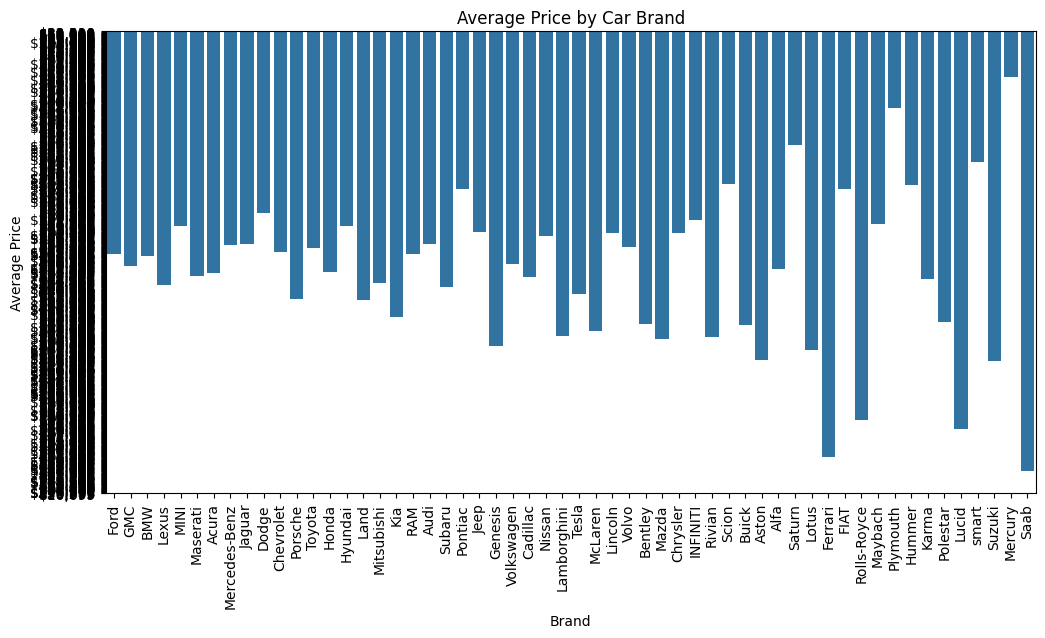

In [113]:
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=df_train, errorbar=None)
plt.title("Average Price by Car Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.show()

Not quite sure how to get rid of that mess of characters on the y axis, but oh well. I really need to study up on graphing in Python. Despite this small issue, it's clear that this is a major step I missed in the data inspection, regardless of my intention to learn graphing at a later time.